# Import and authentication

## Libraries Import

In [469]:
pip install googleapis-common-protos protobuf grpcio pandas systemathics.apis statsmodels matplotlib seaborn scipy

Note: you may need to restart the kernel to use updated packages.


In [470]:
import os
import re
import grpc
import pandas as pd
import seaborn
import statsmodels.api as sm
import google.protobuf as pb
import systemathics.apis.services.static_data.v1.static_data_pb2 as static_data
import systemathics.apis.services.static_data.v1.static_data_pb2_grpc as static_data_service
import numpy as np
from statsmodels.tsa.stattools import adfuller,coint
import matplotlib.pyplot as plt
import systemathics.apis.type.shared.v1.identifier_pb2 as identifier
import systemathics.apis.services.daily.v1.daily_prices_pb2 as daily_prices
import systemathics.apis.services.daily.v1.daily_prices_pb2_grpc as daily_prices_service
from datetime import datetime
import itertools
import copy
from scipy.optimize import minimize

## Authentication Token

In [471]:
token = f"Bearer {os.environ['AUTH0_TOKEN']}"
display(token)

'Bearer eyJhbGciOiJSUzI1NiIsInR5cCI6IkpXVCIsImtpZCI6ImpwZDhjS2Z5Zi13QXkzOURpNENqWSJ9.eyJodHRwOi8vc2NoZW1hcy54bWxzb2FwLm9yZy93cy8yMDA1LzA1L2lkZW50aXR5L2NsYWltcy9lbWFpbGFkZHJlc3MiOiJhcnRodXIudmlub3RAZWR1LmRldmluY2kuZnIiLCJpc3MiOiJodHRwczovL2dhbnltZWRlLXByb2QuZXUuYXV0aDAuY29tLyIsInN1YiI6ImF1dGgwfDYxNmQ4NzI5NWQzZDlkMDA3MGVkYmIxNCIsImF1ZCI6WyJodHRwczovL3Byb2QuZ2FueW1lZGUtcHJvZCIsImh0dHBzOi8vZ2FueW1lZGUtcHJvZC5ldS5hdXRoMC5jb20vdXNlcmluZm8iXSwiaWF0IjoxNjQ3Nzc0MzYyLCJleHAiOjE2NTAzNjYzNjIsImF6cCI6Ijl5R0tzbGtFczFWNm9xRk9aa0h0a1V0NWkyNTVackpJIiwic2NvcGUiOiJvcGVuaWQgcHJvZmlsZSBlbWFpbCIsInBlcm1pc3Npb25zIjpbImFkbWluIiwiYXJ0ZWZhY3RzIiwiY2hhbmdlcyIsImNvbXBvbmVudHMiLCJkYWlseV9iYXJzIiwiZGFpbHlfYm9sbGluZ2VyIiwiZGFpbHlfY21hIiwiZGFpbHlfZW1hIiwiZGFpbHlfbWFjZCIsImRhaWx5X3ByaWNlcyIsImRhaWx5X3JzaSIsImRhaWx5X3NtYSIsImRhaWx5X3ZvbGF0aWxpdHkiLCJkYWlseV92d2FwcyIsImRpdmlkZW5kcyIsImlkZW50aWZpZXJfbWFwcGluZyIsImludHJhZGF5X2JhcnMiLCJpbnRyYWRheV9ib2xsaW5nZXIiLCJpbnRyYWRheV9jbWEiLCJpbnRyYWRheV9lbWEiLCJpbnRyYWRheV9tYWNkIiw

# Pair Creation & Selection

## Selections indicators

### Correlation
We used the numpy library to calculate the correlation coefficient.

In [472]:
def correlation(timeseries1,timeseries2):
    return np.corrcoef(sample1_sum,sample2_sum)[0,1]
# Correlation need to be near 1

### Stationarity
In order to test stationarity we use the statsmodels library. It uses the Augmented Dickey-Fuller unit root test. The null hypothesis tested is thar there is a unit root. We then set a cut-off p-value to separate stationary and non-stationary time-series.

In [473]:
def stationarity_test_bool(timeseries,cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(timeseries, maxlag=3)[1]
    return True if pvalue<cutoff else False

In [474]:
def stationarity_test_pvalue(timeseries):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    return adfuller(timeseries, maxlag=3)[1]


### Cointegration

The cointegration test is made using the statsmodels library as well. But this time we use the augmented Engle-Granger tow-step cointegration test. The null hypothesis tested is no cointegration. The p-value serves as an indicator to determine if two times series are cointegrated.

In [475]:
def cointegration_test(timeseries1,timeseries2):
    return coint(timeseries1,timeseries2, maxlag=3)[1]    # return the p-value of the test


## Data gathering

We want to extract the data from the API in the best format possible so we first setup a template Dataframe to host the data. We then make request through the API to fill the Dataframe

### NASDAQ100 DataFrame

In [476]:
# Define a method to handle the equities reponse using a Pandas dataframe

def get_equities_dataframe(response):
    identifier = ['{0}|{1}'.format(equity.identifier.ticker, equity.identifier.exchange) for equity in response.equities]
    type = [equity.type for equity in response.equities]
    country = [equity.country for equity in response.equities]
    name = [equity.name for equity in response.equities]
    currency = [equity.currency for equity in response.equities]
    primary = [equity.primary for equity in response.equities]
    tick_size_rule = [equity.tick_size_rule for equity in response.equities]
    mapping = [get_mapping(equity.mapping) for equity in response.equities]
    index = [equity.index for equity in response.equities]
    open = [equity.open for equity in response.equities]
    close = [equity.close for equity in response.equities]
    time_zone = [equity.time_zone for equity in response.equities]
    lot_size = [equity.lot_size for equity in response.equities]
    point_value = [equity.point_value for equity in response.equities]
    isin = [equity.isin for equity in response.equities]
    cusip = [equity.cusip for equity in response.equities]
    sedol = [equity.sedol for equity in response.equities]
    sectors = [get_sectors(equity.sectors) for equity in response.equities]
    capitalization = [equity.capitalization.value for equity in response.equities]
    
    # Create pandas dataframe
    d = {'Identifier': identifier, 'Type': type, 'Country': country, 'Name': name, 'Currency': currency, 'Primary': primary, 'TickSizeRule': tick_size_rule, 'Mapping':mapping, 'Index': index, 'Open': open, 'Close': close, 'Time zone': time_zone, 'Lot size': lot_size, 'PointValue': point_value, 'Isin': isin, 'Cusip': cusip, 'Sedol': sedol, 'Sectors': sectors, 'Capitalization': capitalization}
    df = pd.DataFrame(data=d)
    return df

In [477]:
# Define methods to handle identifiers mapping and sectors display as a string

def get_mapping(d):
    res=''
    for key, value in d.items():
        res = res + '['+key+'='+value+']'
    return res

def get_sectors(d):
    res=''
    for key, value in d.items():
        res = res + '['+key+','+value+']'
    return res

def get_identifier(d):
    res=''
    for key, value in d.items():
        res = res + '['+key+'='+value+']'
    return res

In [478]:
# Generate static data API requests

request = static_data.StaticDataRequest( 
    asset_type = static_data.AssetType.ASSET_TYPE_EQUITY
)

#request.index.value = 'Nasdaq 100'
request.exchange.value = 'XNGS'     # This value is only filtering the primary exchange thus not filtering Nasdaq100 assets traded on the Bats Global Markets (BATS)
request.count.value = 1000          # and on the NASDAQ.


<h4> API Request and classification </h4>

The below API call is used to get all informations on the assets in the **selected Stock Exchange and Index**.
We then get a Dataframe used to summarise all these data. We will use this Dataframe later to extract the tickers name of the *NASDAQ100*.
Equities are also divided in various categories in respect to the **primary activity** of the company. We choose the *Standard Industrial Classification* (**SIC**) to **categorize** our differents assets.

In [479]:
# open a gRPC channel
with open(os.environ['SSL_CERT_FILE'], 'rb') as f:
    credentials = grpc.ssl_channel_credentials(f.read())
with grpc.secure_channel(os.environ['GRPC_APIS'], credentials) as channel:
    
    # instantiate the static data service
    service = static_data_service.StaticDataServiceStub(channel)
    
    # process the request
    response = service.StaticData(request = request, metadata = [('authorization', token)])

# visualize request results
data = get_equities_dataframe(response)

data = data[data.Identifier.str.split('|').str[1] == "XNGS"]        # These two lines solves the problems of filtering on exchange
data = data[data.Index.str.contains(r"Nasdaq 100") == True]         # and on the index

data.sort_values('Identifier')

,Identifier,Type,Country,Name,Currency,Primary,TickSizeRule,Mapping,Index,Open,Close,Time zone,Lot size,PointValue,Isin,Cusip,Sedol,Sectors,Capitalization
41,AAPL|XNGS,Equity,US,Apple Inc,USD,XNGS,[0:0.0001][1:0.01],[Idc|564=564|AAPL][Esignal=AAPL][Bloomberg=AAP...,Composite|Industrials|Nasdaq 100|Nasdaq Compos...,,,,1,1.0,US0378331005,037833100,2046251,"[Nasdaq,Computer Manufacturing][SIC,3571 Elect...",2.867249e+12
114,ABNB|XNGS,Equity,US,Airbnb Inc Cl A,USD,XNGS,[0:0.0001][1:0.01],[Idc|564=564|ABNB][Figi=BBG001Y2XS07][Figic=BB...,Nasdaq 100|Nasdaq Composite|nasdaq100,,,,1,1.0,US0090661010,009066101,BMGYYH4,"[SIC,7340 Services-To Dwellings & Other Buildi...",9.649736e+10
5,ADBE|XNGS,Equity,US,Adobe Inc,USD,XNGS,[0:0.0001][1:0.01],[Figic=BBG000BB5006][Figi=BBG000BB5006][Idc|56...,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,,,,1,1.0,US00724F1012,00724F101,2008154,"[Nasdaq,Computer Software: Prepackaged Softwar...",2.142536e+11
44,ADI|XNGS,Equity,US,Analog Devices Inc,USD,XNGS,[0:0.0001][1:0.01],[Idc|564=564|ADI][Reuters=ADI.OQ][Figi=BBG000B...,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,,,,1,1.0,US0326541051,032654105,2032067,"[Nasdaq,Semiconductors][SIC,3674 Semiconductor...",8.593881e+10
21,ADP|XNGS,Equity,US,Automatic Data Processing Inc,USD,XNGS,[0:0.0001][1:0.01],[Idc|564=564|ADP][Figic=BBG000JG0547][Esignal=...,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,,,,1,1.0,US0530151036,053015103,2065308,"[SIC,7374 Services-Computer Processing & Data ...",8.927222e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,WBA|XNGS,Equity,US,Walgreens Boots Alliance Inc,USD,XNGS,[0:0.0001][1:0.01],[Figic=BBG000BWLMJ4][Idc|564=564|WBA][Esignal=...,Composite|Industrials|Nasdaq 100|Nasdaq Compos...,,,,1,1.0,US9314271084,931427108,BTN1Y44,"[SIC,5912 Retail-Drug Stores and Proprietary S...",4.090183e+10
23,WDAY|XNGS,Equity,US,Workday Inc,USD,XNGS,[0:0.0001][1:0.01],[Bloomberg=WDAY US Equity][Reuters=WDAY.OQ][Es...,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,,,,1,1.0,US98138H1014,98138H101,B8K6ZD1,"[Nasdaq,Computer Software: Prepackaged Softwar...",6.095284e+10
8,XEL|XNGS,Equity,US,Xcel Energy Inc,USD,XNGS,[0:0.0001][1:0.01],[Figic=BBG000BCTQ65][Esignal=XEL][Reuters=XEL....,Composite|Nasdaq 100|Nasdaq Composite|Russell ...,,,,1,1.0,US98389B1008,98389B100,2614807,"[SIC,4931 Electric & Other Services Combined][...",3.772490e+10
71,ZM|XNGS,Equity,US,Zoom Video Communications Cl A,USD,XNGS,[0:0.0001][1:0.01],[Esignal=ZM][Bloomberg=ZM US Equity][Idc|564=5...,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,,,,1,1.0,US98980L1017,98980L101,BGSP7M9,"[SIC,7370 Services-Computer Programming, Data ...",3.495862e+10



#### Get Ticker List

We get the ticker list that is to say the list of all equities belonging to the NASDAQ100 index. We will use this list to make price requests for each equity.

In [480]:
def get_ticker_list(data):
    return data.Identifier.str.split('|').str[0].tolist()

In [481]:
ticker_list = get_ticker_list(data)


#### Equities Classification (*SIC*)

This part gets the SIC code in the *Sectors* column of the above Dataframe. The *Standard Industrial Classification* **is made of 4 digits** and the further you go in those digits the **further you specialize**. For example all companies having their SIC code beginning by 0 belong to the *Agricultural, Forestry and Fishing Sectors* but if their second digit is 8 then we can infer that the company primary activity is Forestry. We only limit ourseleves to the **first two digits** of the *SIC* code in order to get a reasonable amount of SIC groups.

In [482]:
def get_sic(data):
    sic = []
    for i in range(len(data)):
        ligne = data.iloc[i]['Sectors']
        match = re.search(r"SIC,([0-9]{2})", ligne)
        sic.append(match.group().split(",")[1])
    data['SIC'] = sic
    return data

In [483]:
data = get_sic(data)


#### Sectors Separation

We create a **list of Dataframes** with each Dataframe containing the information of the equities belonging to the **same group** *(ie. having the same SIC code two first digits)*.

In [484]:
def sep_secteur(data):
    groups = data.groupby(['SIC'])
    liste_sic = data['SIC'].unique()
    liste_sic.sort()
    df_SIC = []
    for i in range(len(liste_sic)):
        df_SIC.append(groups.get_group(liste_sic[i]))
    return df_SIC

In [485]:
data_sec = sep_secteur(data)

In [486]:
data_sec[0]

,Identifier,Type,Country,Name,Currency,Primary,TickSizeRule,Mapping,Index,Open,Close,Time zone,Lot size,PointValue,Isin,Cusip,Sedol,Sectors,Capitalization,SIC
15,MNST|XNGS,Equity,US,Monster Beverage Cp,USD,XNGS,[0:0.0001][1:0.01],[Reuters=MNST.OQ][Bloomberg=MNST US Equity][Es...,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,,,,1,1.0,US61174X1090,61174X109,BZ07BW4,"[Nasdaq,Beverages (Production/Distribution)][S...",4.181935e+10,20
91,MDLZ|XNGS,Equity,US,Mondelez International Ord Shs Class A,USD,XNGS,[0:0.0001][1:0.01],[Idc|564=564|MDLZ][Figi=BBG000D4LWF6][Bloomber...,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,,,,1,1.0,US6092071058,609207105,B8CKK03,"[Nasdaq,Meat/Poultry/Fish][SIC,2000 Food and K...",8.520169e+10,20
96,PEP|XNGS,Equity,US,Pepsico Inc,USD,XNGS,[0:0.0001][1:0.01],[Reuters=PEP.OQ][Figi=BBG000DH7JK6][Idc|564=56...,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,,,,1,1.0,US7134481081,713448108,2681511,"[SIC,2080 Beverages][Nasdaq,Beverages (Product...",2.248939e+11,20
99,KHC|XNGS,Equity,US,Kraft Heinz Company,USD,XNGS,[0:0.0001][1:0.01],[Bloomberg=KHC US Equity][Reuters=KHC.OQ][Esig...,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,,,,1,1.0,US5007541064,500754106,BYRY499,"[SIC,2030 Canned, Frozen & Preserved Fruit, Ve...",4.603711e+10,20
132,KDP|XNGS,Equity,US,Keurig Dr Pepper Inc Common Stock,USD,XNGS,[0:0.0001][1:0.01],[Esignal=KDP][Bloomberg=KDP US Equity][Figic=B...,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,,,,1,1.0,US49271V1008,49271V100,BD3W133,"[Nasdaq,Beverages (Production/Distribution)][S...",5.357802e+10,20


We also create a list only containing the **name of the equities grouped by SIC**.

In [487]:
sic_list = [get_ticker_list(groupe) for groupe in data_sec]

In [488]:
sic_list[0]

['MNST', 'MDLZ', 'PEP', 'KHC', 'KDP']


## Pair Creation

We want to limit the pairs created to companies of the **same sectors**, that is why we used the SIC code to classify all the equities of the NASDAQ100. Using the equities list created above separating equities by SIC code we create all the possible combination of pairs. *For example in a group of 3 equities (A, B and C) we create the following pairs => A/B , A/C and B/C*.

We then get a list of tuple describing **all the possible pairs combinations**.

### Creation of all possible combination for each group

In [489]:
def list_combinations(liste_paires):
    combi = []
    for i in range(len(liste_paires)):
        combi.append(list(itertools.combinations(liste_paires[i],2)))
    return [x for sublist in combi for x in sublist if x != []]

In [490]:
combinations = list_combinations(sic_list)


### Price request for each pair

We make an api call for each ticker, requesting prices over the longest time period possible. 

#### Fonction qui va requêter les prix à travers l'API

In [491]:
def price_request(ticker, exchange):
    request = daily_prices.DailyPricesRequest( identifier = identifier.Identifier(exchange = exchange, ticker = ticker))
    
    # open a gRPC channel
    with open(os.environ['SSL_CERT_FILE'], 'rb') as f:
        credentials = grpc.ssl_channel_credentials(f.read())
    with grpc.secure_channel(os.environ['GRPC_APIS'], credentials) as channel:

        # instantiate the daily prices service
        service = daily_prices_service.DailyPricesServiceStub(channel)

        # process the daily prices request
        return service.DailyPrices(request = request, metadata = [('authorization', token)])


#### Cache

We store the prices for each ticker in a cache so we don't have to call the API every time we need the prices for a given equity.

In [492]:
%%time
cache = pd.DataFrame({'Name' : ticker_list, 'Data' : [price_request(x, 'XNGS') for x in ticker_list]})

CPU times: user 2.95 s, sys: 536 ms, total: 3.48 s
Wall time: 30.2 s


In [493]:
cache.loc[:,'Name']

0     TEAM
1     DDOG
2     ADBE
3     CSCO
4     QCOM
      ... 
90    TMUS
91    VRSK
92    FISV
93    REGN
94     KDP
Name: Name, Length: 95, dtype: object

We request the price **for each pair** by calling the cache. For each pair we use the largest time frame available *(ie. the smallest of the two)*. We store all the prices in a **list of Dataframe** containing 3 columns *(Date, Price_A, Price_B)*. We drop the pairs having **less than a hundred data points** as we considered them as inexploitable.

In [494]:
def df_paire(paire, exchange, cache):
    response1 = cache.iloc[int(cache.index[cache['Name'] == paire[0]].values), 1]
    response2 = cache.iloc[int(cache.index[cache['Name'] == paire[1]].values), 1]
    
    # prepare the dataframe content
    dates1 = [datetime(p.date.year, p.date.month, p.date.day) for p in response1.data]
    dates2 = [datetime(p.date.year, p.date.month, p.date.day) for p in response2.data]
    if (len(dates1) <= len(dates2)):
        dates = dates1
    else:
        dates = dates2
    prices1 = [p.price for p in response1.data][-len(dates):]       # So all arrays have the same length
    prices2 = [p.price for p in response2.data][-len(dates):]

    d = {'Date': dates, f'{paire[0]}': prices1, f'{paire[1]}': prices2}
    return pd.DataFrame(data=d)

In [495]:
def pair_combination(combinations, exchange, cache):
    temp = [df_paire(x, exchange, cache) for x in combinations]
    return [x for x in temp if len(x) > 100]

In [496]:
%%time
df_combi = pair_combination(combinations, 'XNGS', cache)

CPU times: user 22.4 s, sys: 38.2 ms, total: 22.4 s
Wall time: 22.5 s



## Separation Between training and test data

We separate the data in 2 sets, the **training set** and the **test set**. We separate them according to the date passed as parameters.


#### Data Splitting


In [497]:
def sep_tableau_train_test(df, train_start_date, train_end_date, test_end_date):
    test_start_date = train_end_date
    
    test = []
    train = []
    for i in range(len(df)):
        if (df[i].Date.iloc[0] <= train_start_date):
            train_date = (df[i]['Date'] >= train_start_date) & (df[i]['Date'] < train_end_date)
            test_date = (df[i]['Date'] >= test_start_date) & (df[i]['Date'] <= test_end_date)
            train.append(df[i].loc[train_date])
            test.append(df[i].loc[test_date])
            
    return train, test

In [498]:
train_start_date = np.datetime64('2014-01-01')
train_end_date = np.datetime64('2019-01-01')
test_end_date = np.datetime64('2021-01-01')

In [499]:
train, test = sep_tableau_train_test(df_combi, train_start_date, train_end_date, test_end_date)

In [500]:
### Calculation of the number of pairs created

"Number of pairs = " + str(len(test))

'Number of pairs = 328'

In [501]:
def addMonths(date):
    b = pd.Timestamp(date) + pd.DateOffset(months=1)
    return b

In [502]:
def subtractMonths(date):
    b = pd.Timestamp(date) - pd.DateOffset(months=1)
    return b


## Pair Selection functions

We group all the selection functions here.

#### Cointegration

In [503]:
def coint_df(df):
    df.loc[:,'Cointegration'] = pd.Series(cointegration_test(df.iloc[:,1], df.iloc[:,2]), index = df.index[[0]])
    return df

In [504]:
def add_coint(df_combi):
    return [coint_df(x) for x in copy.deepcopy(df_combi)]

#### Stationarity

In [505]:
def statio_df(df, column_name, indicateur):
    df[column_name] = pd.Series(stationarity_test_pvalue(df[indicateur]), index = df.index[[0]])
    return df

In [506]:
def add_statio(df, column_name, indicateur):
    return [statio_df(x, column_name, indicateur) for x in copy.deepcopy(df)]

#### Ratio

In [507]:
def ratio_df(df):
    df['Ratio'] = df.iloc[:,1] / df.iloc[:,2]
    return df

In [508]:
def add_ratio_list_df(df):
    return add_statio(df, 'Statio_Ratio', 'Ratio')

#### Log-Ratio

In [509]:
def log_ratio_df(df):
    df['Log_Ratio'] = np.log(df.iloc[:,1] / df.iloc[:,2])
    return df

In [510]:
def add_log_list_df(df):
    return add_statio(df, 'Statio_Log_Ratio', 'Log_Ratio')

#### Adding ratios to DF

In [511]:
def add_ratios(df):
    df_copy = [ratio_df(x) for x in copy.deepcopy(df)]
    return [log_ratio_df(x) for x in df_copy]

#### Removing non-cointegrated pairs

In [512]:
def drop_faible_coint(train, threshold):    # Retourne une liste de paires suffisament cointégrés
    return [x for x in train if (x['Cointegration'].iloc[0] < threshold)]


#### Removing non-stationary pairs according to the indicator

In this case the indicator chosen is $ log(A/B) $

In [513]:
def drop_faible_statio(df_combi, threshold):
    df_combi_copy = []
    count_ratio = 0
    count_log = 0
    same = 0

    for x in df_combi:
        if x['Statio_Log_Ratio'].iloc[0] < threshold:
            count_log += 1
            
    return [x for x in df_combi if (x['Statio_Log_Ratio'].iloc[0] < threshold)], count_log

#### Cointégration


### Pair selection Functions

These functions aggregates all the selection functions. We apply the selection to the training set and to the test set.

In [514]:
def pair_selection(train):
    df_coint = add_coint(train)
    df = [x for x in df_coint if (x['Cointegration'].iloc[0] < 0.05)]
    print("drop_faible_coint OK")
    df = add_ratios(df)
    print("Add_Ratios OK")
    df = add_log_list_df(df)
    print("Add_Log_List OK")
    df = add_ratio_list_df(df)
    print("Add_Ratio_List OK")
    return drop_faible_statio(df, 0.05)

In [515]:
def test_selection(train, test):
    train_list = [list(x.columns)[:3] for x in train]
    return [x for x in test if list(x.columns) in train_list]

In [516]:
def test_selection_full(train, test):
    return [x for x in test]

In [517]:
%%time
train, log_score = pair_selection(df_coint) # 7 paires
test = test_selection(train, test)

drop_faible_coint OK
Add_Ratios OK
Add_Log_List OK
Add_Ratio_List OK
CPU times: user 5.43 s, sys: 9.43 ms, total: 5.44 s
Wall time: 5.49 s



### Train and Test Example

We visualize the train set and the test set for a given pair

In [518]:
train[-1]

,Date,CDNS,ADSK,Cointegration,Ratio,Log_Ratio,Statio_Log_Ratio,Statio_Ratio
3269,2014-01-02,14.010,49.25,0.02887,0.284467,-1.257138,0.04306,0.04429
3270,2014-01-03,14.170,48.90,NaN,0.289775,-1.238650,NaN,NaN
3271,2014-01-06,14.270,48.55,NaN,0.293924,-1.224435,NaN,NaN
3272,2014-01-07,14.335,49.68,NaN,0.288547,-1.242898,NaN,NaN
3273,2014-01-08,14.420,50.24,NaN,0.287022,-1.248195,NaN,NaN
...,...,...,...,...,...,...,...,...
4522,2018-12-24,40.310,118.32,NaN,0.340686,-1.076793,NaN,NaN
4523,2018-12-26,42.590,125.93,NaN,0.338204,-1.084107,NaN,NaN
4524,2018-12-27,43.410,127.41,NaN,0.340711,-1.076720,NaN,NaN
4525,2018-12-28,43.340,127.23,NaN,0.340643,-1.076920,NaN,NaN


In [519]:
test[-1]

,Date,CDNS,ADSK
4527,2019-01-02,43.23,128.96
4528,2019-01-03,41.53,121.85
4529,2019-01-04,43.26,128.28
4530,2019-01-07,43.42,132.72
4531,2019-01-08,43.67,133.87
...,...,...,...
5027,2020-12-24,134.00,301.39
5028,2020-12-28,134.76,299.65
5029,2020-12-29,133.98,298.11
5030,2020-12-30,135.25,299.41



### Graph

We plot the test set of the first pair to check if the algorithm works as expected

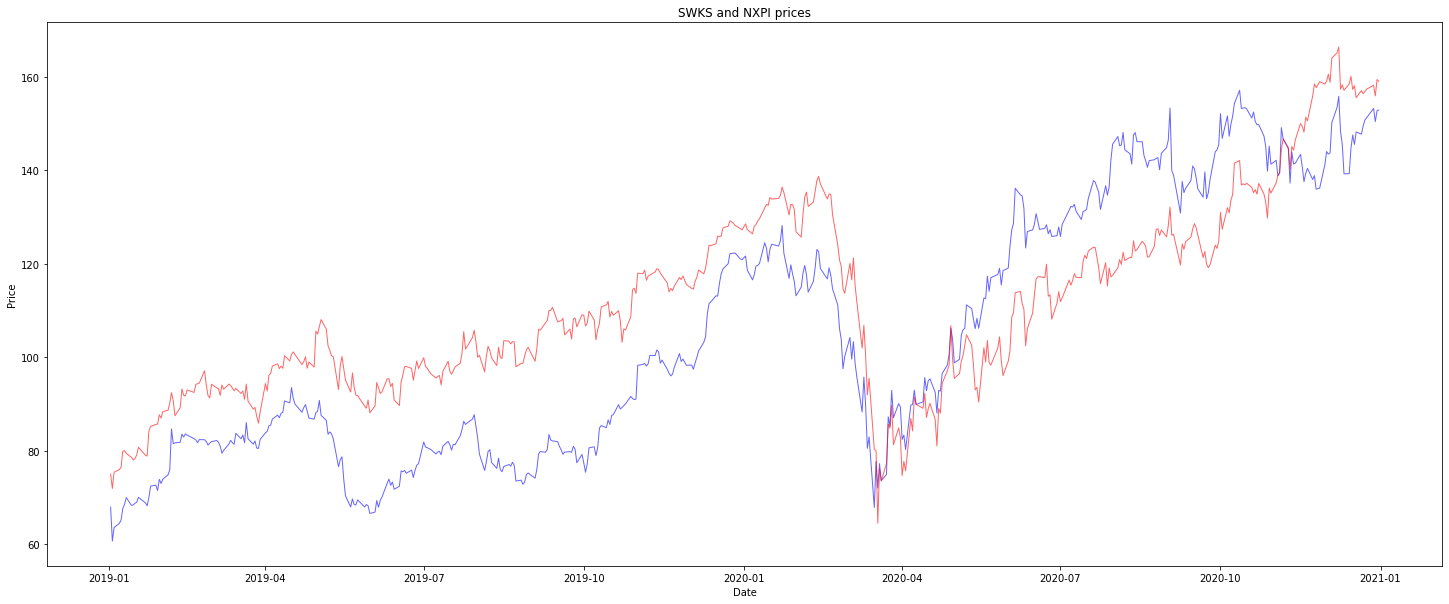

In [521]:
plt.figure(figsize=(25, 10))
plt.plot('Date', test[0].columns[1], data=test[0], marker='', color='blue', linewidth=1, alpha = 0.6)
plt.plot('Date', test[0].columns[2], data=test[0], marker='', color='red', linewidth=1, alpha = 0.6)
plt.ylabel('Price')
plt.xlabel('Date')
plt.title("{} and {} prices".format(test[0].columns[1],test[0].columns[2]))
plt.show()

## Score de la sélection des paires

In [427]:
print("There are {} selected pairs.".format(str(log_score)) + '\n')

for i in range(len(test)):
    print("Asset A: " + str(test[i].columns[1])," // Asset B: " + str(test[i].columns[2]))

There are 8 selected pairs.

Asset A: SWKS  // Asset B: NXPI
Asset A: TSLA  // Asset B: HON
Asset A: ADP  // Asset B: VRSK
Asset A: INTU  // Asset B: MSFT
Asset A: FB  // Asset B: EA
Asset A: EBAY  // Asset B: EA
Asset A: MELI  // Asset B: ADSK
Asset A: CDNS  // Asset B: ADSK


# Investissement

In [430]:
# We define the main parameters 

window = 30                # rolling windows for the calcul_moyenne_mobile function
freq_reb = 30              # rebalancing frequencing for the portfolio
stoploss_value = 4 
cash = 100000

In [396]:
def calcul_moyenne_mobile(liste_df,window):
    liste_df = [log_ratio_df(df) for df in copy.deepcopy(liste_df)]
    #liste_df = [ratio_df(df) for df in liste_df]
    
    for i in range(len(liste_df)):
        # Calcul de la moyenne mobile
        rolling_window = liste_df[i]['Log_Ratio'].rolling(window=window, center=False)
        rolling_window_mean = rolling_window.mean()
        rolling_window_std  = rolling_window.std()

        Z_score_rolling = (liste_df[i]['Log_Ratio'] - rolling_window_mean) / rolling_window_std
        liste_df[i]['Zscore_rolling'] = Z_score_rolling
    return liste_df


In [397]:
test = calcul_moyenne_mobile(test,window)


## Graph 

We plot the investment graph

In [524]:
def graph_invest(df, stoploss_value):
    # Band
    # Z-Score
    #plt.figure(figsize=(25, 10))
    #plt.plot('Date', 'Zscore_rolling', data=df, marker='', color='blue', linewidth=1, alpha =  0.6, label='Zscore_rolling')
    
    df["2STD_Log_Ratio"] =  stoploss_value * df['STD_Log_Ratio']
    df["-2STD_Log_Ratio"] = -stoploss_value * df['STD_Log_Ratio']
    df["-STD_Log_Ratio"] = -df['STD_Log_Ratio']
    
    plt.figure(figsize=(25, 10))
    plt.plot('Date', 'Zscore_rolling', data=df, marker='', color='blue', linewidth=1, alpha =  0.6, label='Zscore_rolling')
    plt.plot('Date', 'STD_Log_Ratio', data=df, marker='', color='green', linewidth=1, alpha =  0.6, label='1 * Sigma')
    plt.plot('Date', '2STD_Log_Ratio', data=df, marker='', color='red', linewidth=1, alpha =  0.6, label='2 * Sigma')
    plt.plot('Date', '-STD_Log_Ratio', data=df, marker='', color='green', linewidth=1, alpha =  0.6, label='-1 * Sigma')
    plt.plot('Date', '-2STD_Log_Ratio', data=df, marker='', color='red', linewidth=1, alpha =  0.6, label='-2 * Sigma')
    
    position = False 
    for i in range(len(df)):
        if (df.Status.iloc[i] == "Upper" or df.Status.iloc[i] == "Lower") and position == False: # Entry rule
            plt.plot(df.Date.iloc[i], df.Zscore_rolling.iloc[i], color='green', linestyle='None', marker='o')
            position = True
        
        elif df.Status.iloc[i] == "Time Limit" and position == True: #Time limit
            plt.plot(df.Date.iloc[i], df.Zscore_rolling.iloc[i], color='grey', linestyle='None', marker='o')
            position = False
            
        elif df.Status.iloc[i] == "Stop Loss" and position == True: # Stop loss 
            plt.plot(df.Date.iloc[i], df.Zscore_rolling.iloc[i], color='red', linestyle='None', marker='^')
            position = False
        
        elif df.Status.iloc[i] == "Clear" and position == True: # Exit Rule
            plt.plot(df.Date.iloc[i], df.Zscore_rolling.iloc[i], color='orange', linestyle='None', marker='s')
            position = False
                  
    plt.axhline(0, color = 'grey')
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.title("Zscore for pair {} and {}".format(df.columns[1],df.columns[2]))
    plt.legend()
    plt.show()
    

In [459]:
def selected(train,test,freq_reb,train_end_date,test_end_date): 
    for i in range(len(test)):
        #reloop = False
        test[i]['selected'] = False
        current_date = addMonths(train_end_date)
        while current_date < test_end_date:# or reloop = False:
            train_split = train[i].iloc[:,:3]
            test_split = test[i].loc[(test[i]['Date'] >= train_end_date) & (test[i]['Date'] < current_date)]
            test_split = test_split.iloc[:,:3]
            df_train_concat = pd.concat([train_split,test_split], ignore_index=True)
            #df_train_concat['Cointegration'] = pd.Series(cointegration_test(df_train_concat.iloc[:,1], df_train_concat.iloc[:,2]), index = df_train_concat.index[[0]])
            #print(df_coint)
            #Stationnarité plutôt ici
            
            test[i].loc[((test[i]['Date'] >= subtractMonths(current_date)) & (test[i]['Date'] < current_date)), 'selected'] = True
        #train, ratio_score, log_score, same = pair_selection(train)
            #train, test = sep_tableau_train_test(df_combi, train_start_date, train_end_date, test_end_date)
            
            current_date =  addMonths(current_date)
            
        train_split = train[i].iloc[:,:3]
        test_split = test[i].loc[(test[i]['Date'] >= train_end_date) & (test[i]['Date'] < current_date)]
        test_split = test_split.iloc[:,:3]
        df_train_concat = pd.concat([train_split,test_split], ignore_index=True)
            #df_train_concat['Cointegration'] = pd.Series(cointegration_test(df_train_concat.iloc[:,1], df_train_concat.iloc[:,2]), index = df_train_concat.index[[0]])
            #print(df_coint)
            
        test[i].loc[((test[i]['Date'] >= subtractMonths(current_date)) & (test[i]['Date'] < current_date)), 'selected'] = True
    
    return test

In [460]:
test = selected(train,test,freq_reb,train_end_date,test_end_date)

In [462]:
def invest(df, stoploss_value, invest_value):
    vol_A = [0]
    vol_B = [0]
    total = [invest_value]
    #ratio = list(df.Ratio)
    price_A = list(df.iloc[:,1])
    price_B = list(df.iloc[:,2])
    day_count = 0
    count = [0]
    position = False
    status = ['']
    time_limit = 50
    cash = invest_value
    df['STD_Log_Ratio'] = df['Log_Ratio'].rolling(window = 50).std() * np.sqrt(256)
    mean_return = True
        

    
    for i in range(len(df)):
        if df["selected"].iloc[i] == True or df["Status"].iloc[i] == "Position":
            if np.sign(df['Zscore_rolling'].iloc[i]) != np.sign(df['Zscore_rolling'].iloc[i-1]) :
                mean_return = True
                
            if abs(df['Zscore_rolling'].iloc[i]) > stoploss_value * df['STD_Log_Ratio'].iloc[i] and  position == True:   # Stop-loss / Valeur absolue
                total.append(cash + vol_A[-1] * price_A[i] + vol_B[-1] * price_B[i])
                cash = total[-1]
                vol_A.append(0)
                vol_B.append(0)
                day_count = 0
                count.append(day_count)
                position = False
                status.append("Stop Loss")
                mean_return = False #rendement diminue 

            elif df['Zscore_rolling'].iloc[i] * df['Zscore_rolling'].iloc[i-1]  < 0 and position == True:   # Clear Positions
                total.append(cash + vol_A[-1] * price_A[i] + vol_B[-1] * price_B[i])
                cash = total[-1]
                vol_A.append(0)
                vol_B.append(0)
                day_count = 0
                count.append(day_count)
                position = False
                status.append("Clear")

            elif day_count > time_limit and position == True:    # Time-Limit
                total.append(cash + vol_A[-1] * price_A[i] + vol_B[-1] * price_B[i])
                cash = total[-1]
                vol_A.append(0)
                vol_B.append(0)
                day_count = 0
                count.append(day_count)
                position = False
                status.append("Time Limit")

            elif ((df['Zscore_rolling'].iloc[i-1] > df['STD_Log_Ratio'].iloc[i]) and (df['Zscore_rolling'].iloc[i] < df['STD_Log_Ratio'].iloc[i]) and (0 < df['Zscore_rolling'].iloc[i] < df['STD_Log_Ratio'].iloc[i])) or position == True: #and (-entry_value <= df['Zscore_rolling'].iloc[i-1] <= entry_value):# and (df['Zscore_rolling'].iloc[i-1] > entry_value and df['Zscore_rolling'].iloc[i] < entry_value):#and (df['Zscore_rolling'].iloc[i] < df['Zscore_rolling'].iloc[i-1]) :    # Zscore above band (df['Zscore_rolling'].iloc[i] - df['Zscore_rolling'].iloc[i-1]) < 0
                if (position == False) and (mean_return == True):
                    vol_A.append(- (total[-1]/2) / price_A[i])           # Sell A
                    vol_B.append(+ (total[-1]/2) / price_B[i])       # Buy B
                    total.append(total[-1])#+ vol_A[-1] * price_A[i] + vol_B[-1] * price_B[i]''')
                    position = True
                    day_count = 0
                    count.append(day_count)
                    status.append("Upper")
                else:
                    vol_A.append(vol_A[-1])
                    vol_B.append(vol_B[-1])
                    total.append(cash + vol_A[-1] * price_A[i] + vol_B[-1] * price_B[i])
                    day_count += 1
                    count.append(day_count)
                    status.append("Position")

            elif ((df['Zscore_rolling'].iloc[i-1] < -df['STD_Log_Ratio'].iloc[i]) and (df['Zscore_rolling'].iloc[i] > -df['STD_Log_Ratio'].iloc[i]) and (-df['STD_Log_Ratio'].iloc[i] < df['Zscore_rolling'].iloc[i] < 0)) or position == True: #df['Zscore_rolling'].iloc[i] < -entry_value and (-entry_value <= df['Zscore_rolling'].iloc[i-1] <= entry_value):# and (df['Zscore_rolling'].iloc[i-1] < -entry_value and df['Zscore_rolling'].iloc[i] > -entry_value) : #and (df['Zscore_rolling'].iloc[i] > df['Zscore_rolling'].iloc[i-1]) :     # Zscore under band (df['Zscore_rolling'].iloc[i] - df['Zscore_rolling'].iloc[i-1]) < 0
                if (position == False) and (mean_return == True):
                    vol_A.append(+ (total[-1]/2) / price_A[i])          # Buy A
                    vol_B.append(- (total[-1]/2) / price_B[i])     # Sell B
                    total.append(cash + vol_A[-1] * price_A[i] + vol_B[-1] * price_B[i])
                    position = True
                    day_count = 0
                    count.append(day_count)
                    status.append("Lower")
                else:
                    vol_A.append(vol_A[-1])
                    vol_B.append(vol_B[-1])
                    total.append(cash + vol_A[-1] * price_A[i] + vol_B[-1] * price_B[i])
                    day_count += 1
                    count.append(day_count)
                    status.append("Position")
                
            elif position == True:
                vol_A.append(vol_A[-1])
                vol_B.append(vol_B[-1])
                total.append(cash + vol_A[-1] * price_A[i] + vol_B[-1] * price_B[i])
                day_count += 1
                count.append(day_count)
                status.append("Position")
                
            else:
                vol_A.append(vol_A[-1])
                vol_B.append(vol_B[-1])
                total.append(total[-1])# + vol_A[-1] * price_A[i] + vol_B[-1] * price_B[i])
                day_count += 1
                count.append(day_count)
                status.append("No Position")
                
        else:
            vol_A.append(vol_B[-1])
            vol_B.append(vol_B[-1])
            total.append(total[-1])
            day_count += 1
            count.append(day_count)
            status.append("No position")
            

    df['Vol_A'] = vol_A[1:]
    df['Vol_B'] = vol_B[1:]
    df['Total'] = total[1:]
    df['Status'] = status[1:]
    df['Day_count'] = count[1:]
    
    return df

In [402]:
df_test = [invest(df, stoploss_value, cash/len(test)) for df in test]

In [542]:
df_test[-1].iloc[50:150]

,Date,CDNS,ADSK,Log_Ratio,Zscore_rolling,selected,STD_Log_Ratio,Vol_A,Vol_B,Total,Status,Day_count,2STD_Log_Ratio,-2STD_Log_Ratio,-STD_Log_Ratio,Log_Return
4577,2019-03-15,60.99,153.28,-0.921556,1.598774,True,1.075742,0.000000,0.000000,12500.000000,No Position,51,4.302969,-4.302969,-1.075742,0.000000e+00
4578,2019-03-18,61.06,153.85,-0.924121,1.449541,True,1.123719,0.000000,0.000000,12500.000000,No Position,52,4.494876,-4.494876,-1.123719,0.000000e+00
4579,2019-03-19,61.24,155.10,-0.929269,1.287602,True,1.163598,0.000000,0.000000,12500.000000,No Position,53,4.654390,-4.654390,-1.163598,0.000000e+00
4580,2019-03-20,61.45,154.31,-0.920740,1.303167,True,1.199158,0.000000,0.000000,12500.000000,No Position,54,4.796631,-4.796631,-1.199158,0.000000e+00
4581,2019-03-21,63.08,158.82,-0.923368,1.185411,True,1.228148,-99.080533,39.352726,12500.000000,Upper,0,4.912591,-4.912591,-1.228148,0.000000e+00
4582,2019-03-22,61.76,154.22,-0.915124,1.204070,True,1.252025,-99.080533,39.352726,12449.763762,Position,1,5.008099,-5.008099,-1.252025,-4.026997e-03
4583,2019-03-25,62.11,154.69,-0.912516,1.159097,True,1.276750,-99.080533,39.352726,12433.581357,Position,2,5.107001,-5.107001,-1.276750,-1.300662e-03
4584,2019-03-26,62.30,155.91,-0.917317,1.031565,True,1.295801,-99.080533,39.352726,12462.766382,Position,3,5.183205,-5.183205,-1.295801,2.344524e-03
4585,2019-03-27,61.83,153.10,-0.906703,1.103730,True,1.320617,-99.080533,39.352726,12398.753071,Position,4,5.282469,-5.282469,-1.320617,-5.149601e-03
4586,2019-03-28,62.65,153.03,-0.893070,1.230512,True,1.351988,-99.080533,39.352726,12314.752343,Position,5,5.407951,-5.407951,-1.351988,-6.797988e-03


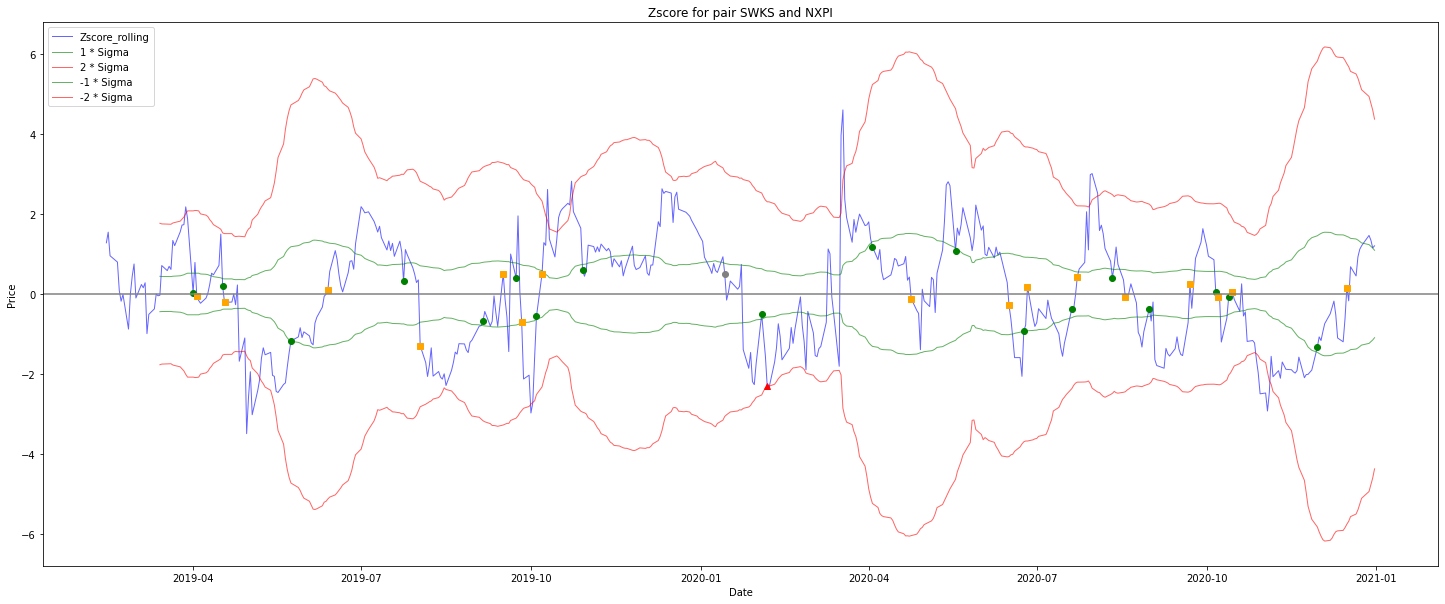

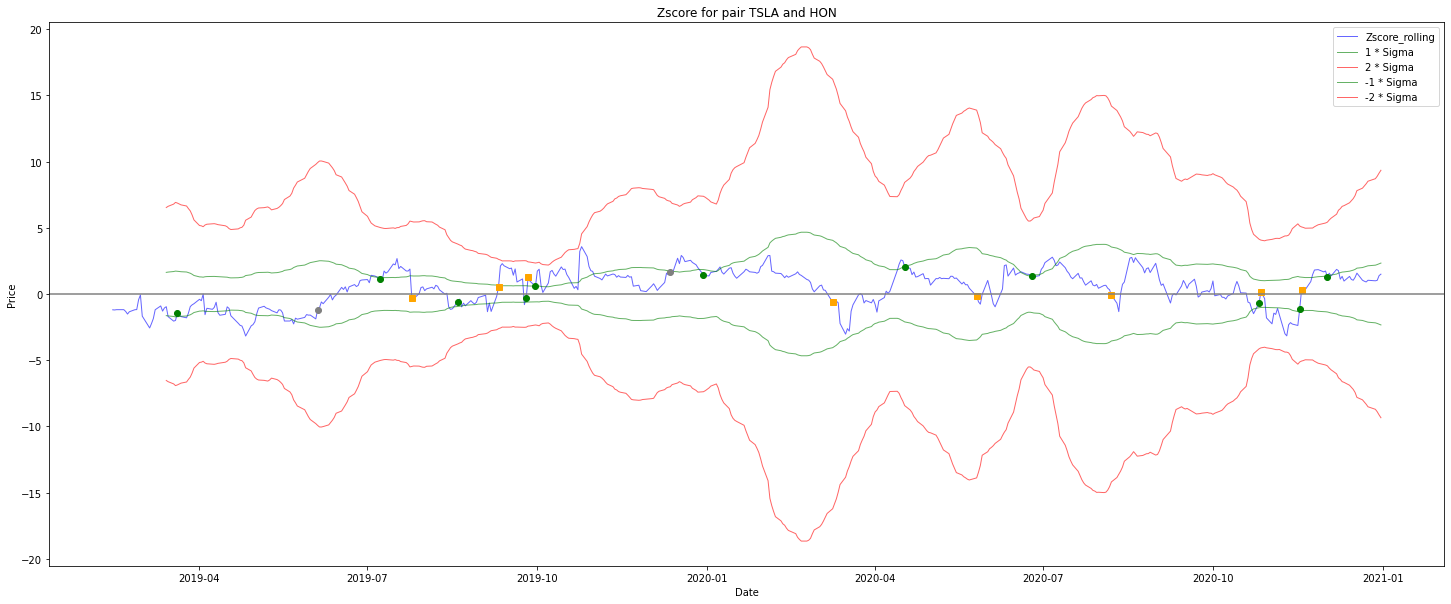

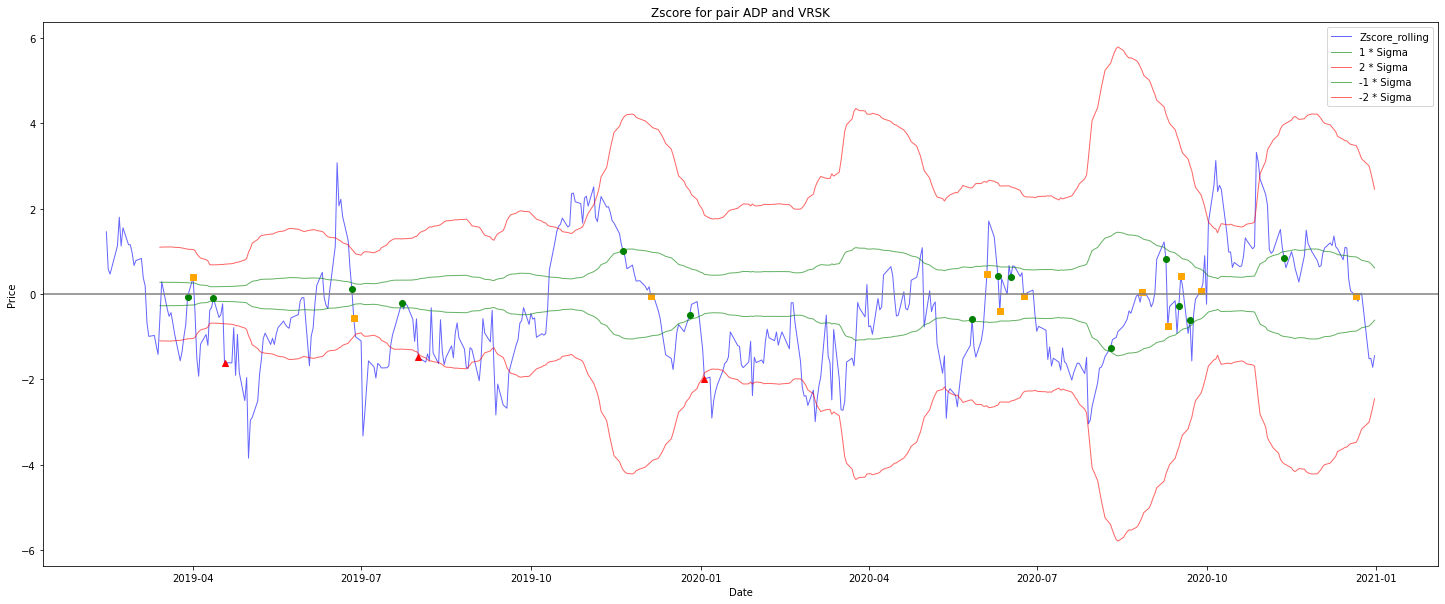

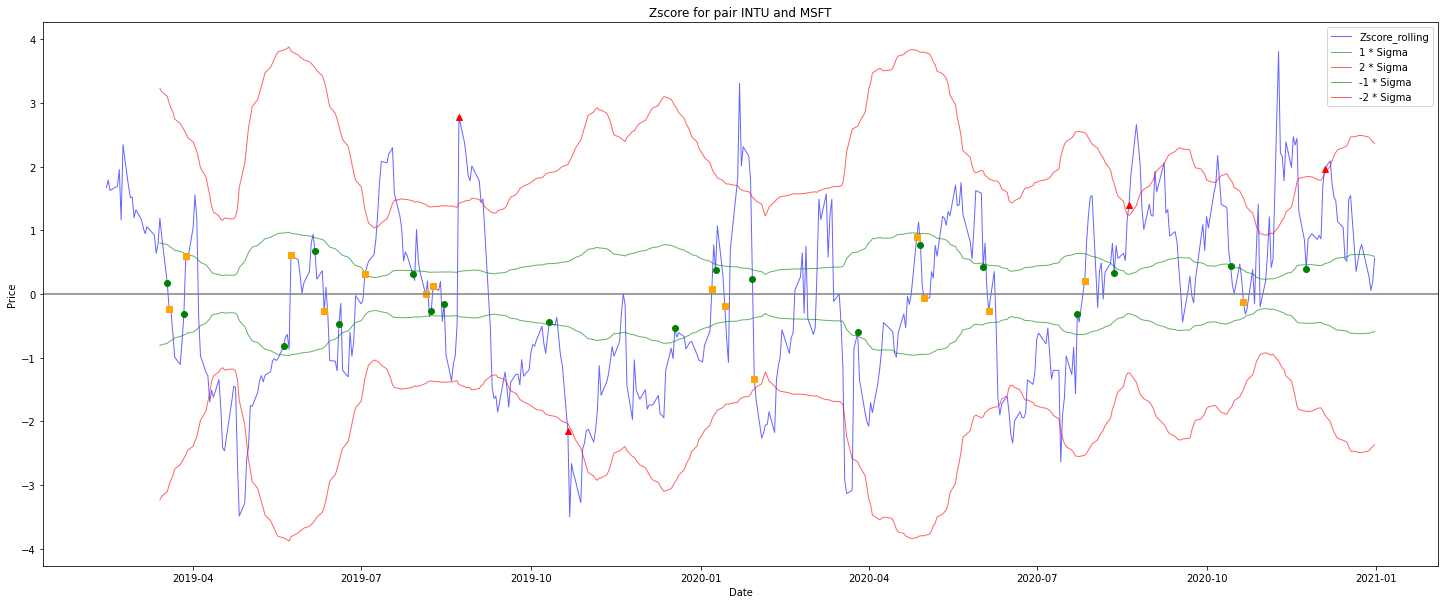

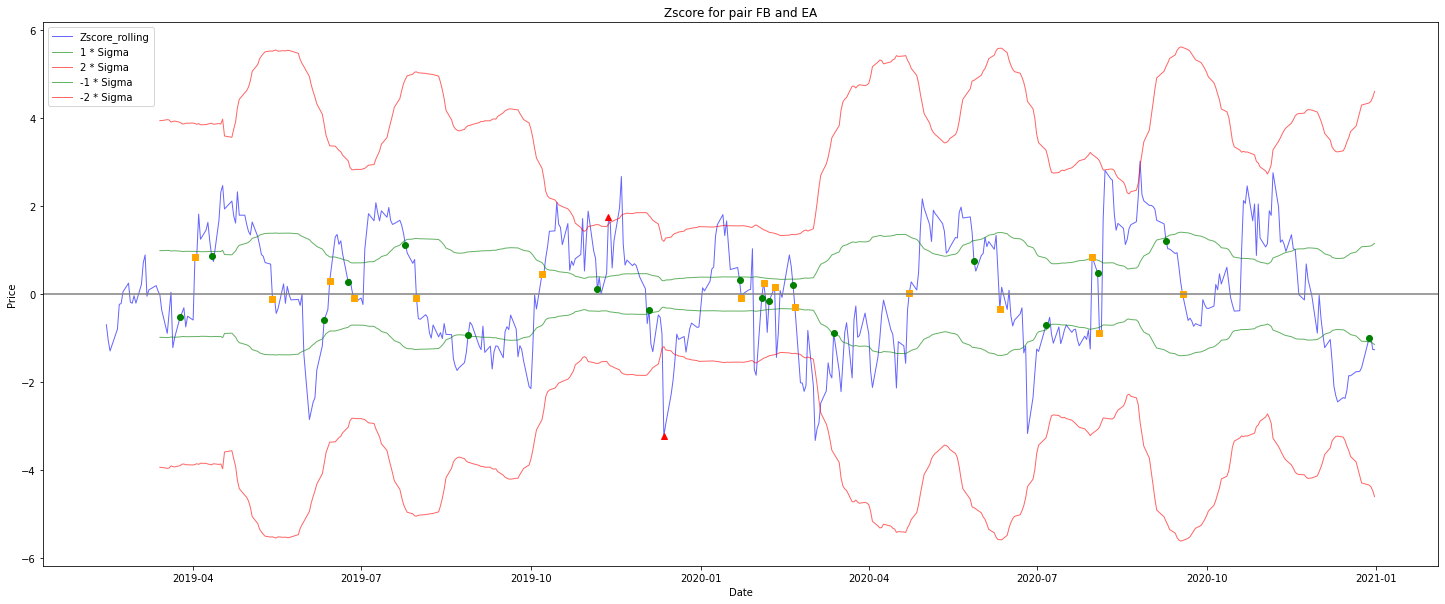

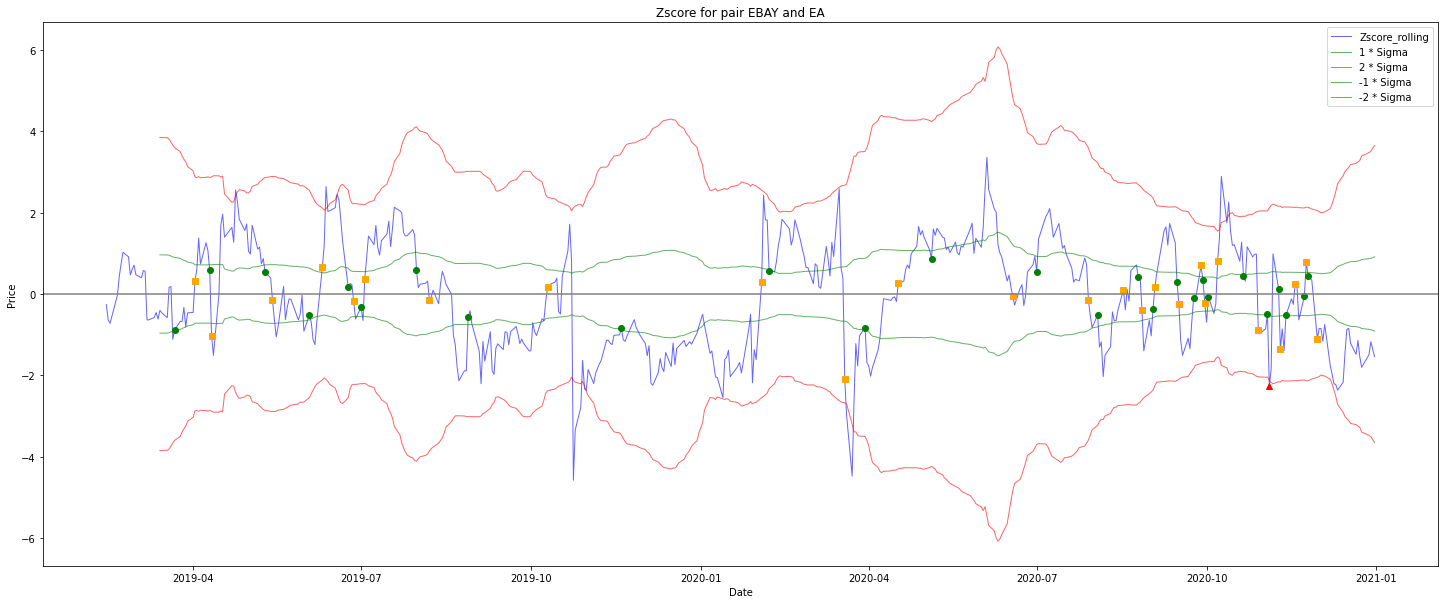

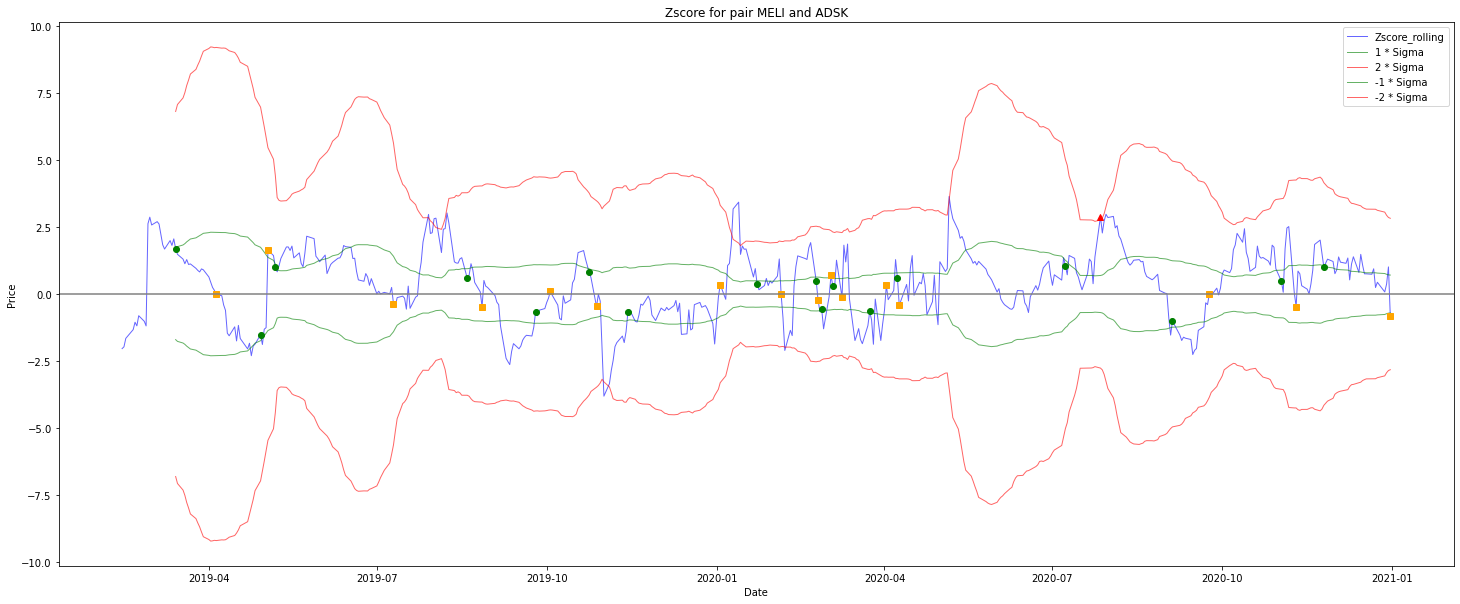

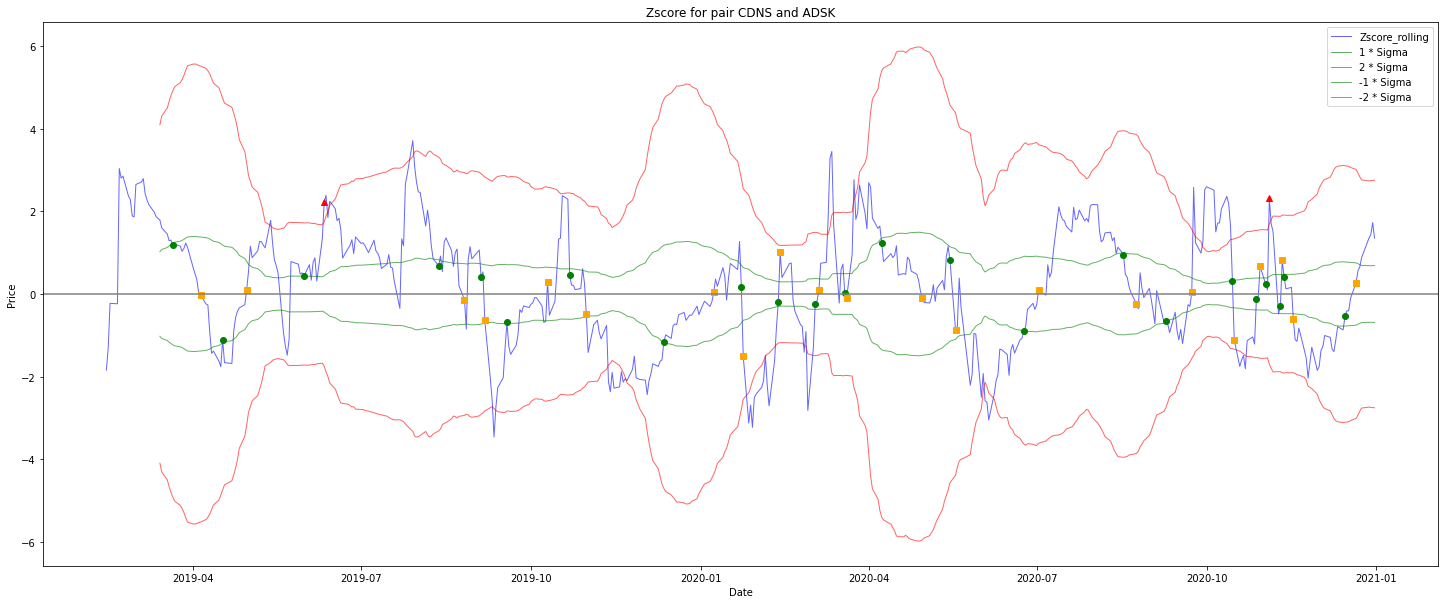

In [525]:
for i in range(len(df_test)):
    graph_invest(df_test[i],stoploss_value)

In [404]:
def display_profit(df_list):
    df_profit = pd.DataFrame(columns=['Name_A','Name_B','Profit'])
    index = 0
    for i in range(len(df_list)):
        df_profit = pd.concat([df_profit, pd.DataFrame(data = {'Name_A':df_list[i].columns[1], 'Name_B':df_list[i].columns[2], 'Profit':df_list[i].Total.iloc[-1]}, index = [index])])
        index += 1
    return df_profit

In [405]:
df_final = display_profit(df_test)

In [406]:
print(df_final)

  Name_A Name_B        Profit
0   SWKS   NXPI  12451.337615
1   TSLA    HON   4374.707079
2    ADP   VRSK  13151.113794
3   INTU   MSFT  13203.320984
4     FB     EA   12453.37113
5   EBAY     EA  13805.309835
6   MELI   ADSK  14084.211161
7   CDNS   ADSK  14855.594906


In [407]:
print("Le rendement de la stratégie est de {}% sur la période de test".format((df_final.Profit.sum() / cash)))

Le rendement de la stratégie est de 0.9837896650400327% sur la période de test


In [526]:
def Sharpe(df):
    df["Log_Return"] = np.log(df["Total"] / df["Total"].shift(1))
    L = list(abs(df["Log_Return"].rolling(window=100).mean()/df["Log_Return"].rolling(window=100).std()))
    plt.plot([i for i in range(len(L))],L)
    plt.title("Sharpe Ratio for pair {} and {}".format(df.columns[1],df.columns[2]))
    plt.show()

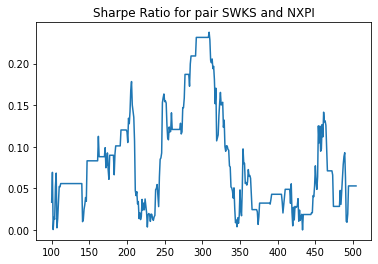

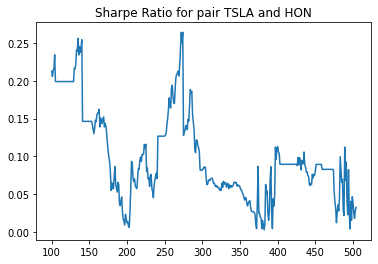

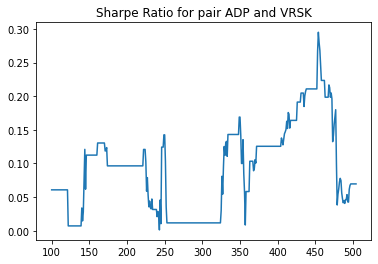

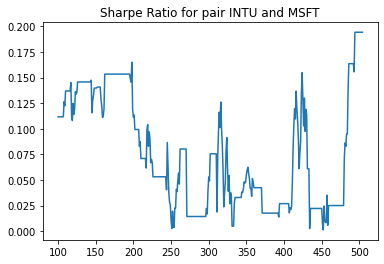

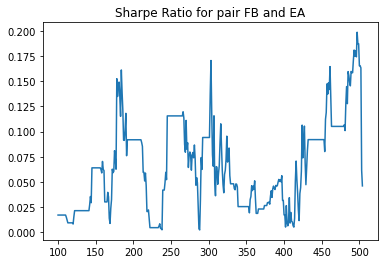

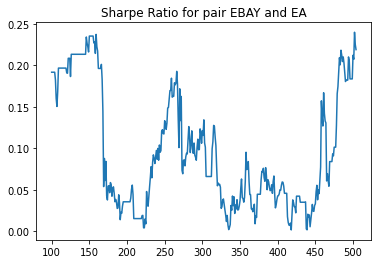

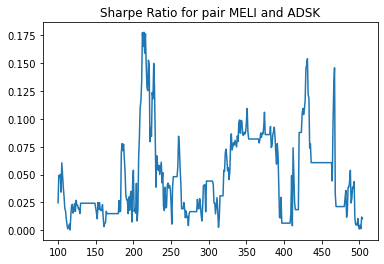

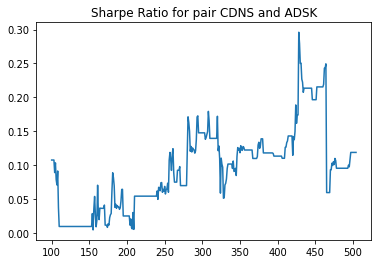

In [527]:
for i in range(len(df_test)):
    Sharpe(df_test[i])

In [528]:
def Profit_Loss(df):
    plt.plot(df['Date'], df['Total'], label = 'Cash Total')
    plt.axhline(df.Total.iloc[0], color = 'red', label = 'Starting Investment')
    plt.legend()
    plt.title("Total result for pair {} and {}".format(df.columns[1],df.columns[2]))
    plt.show()

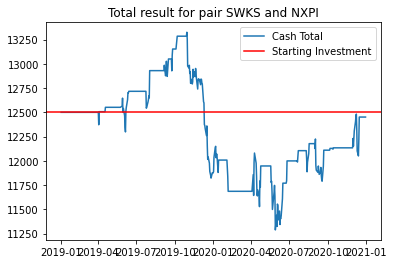

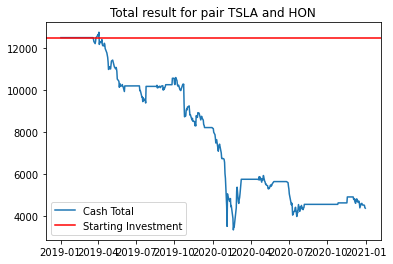

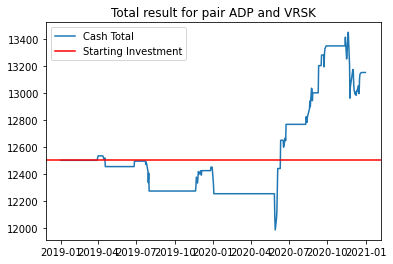

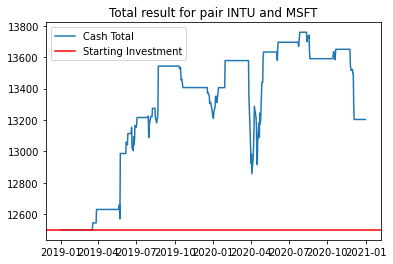

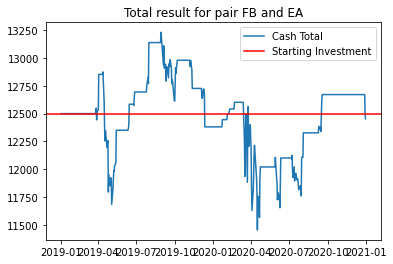

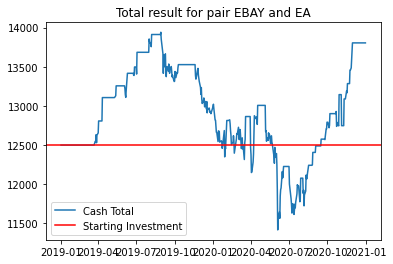

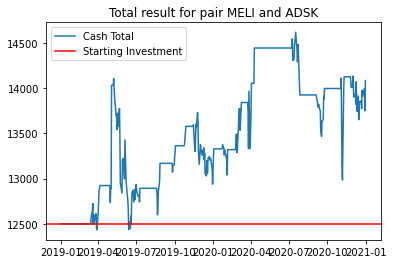

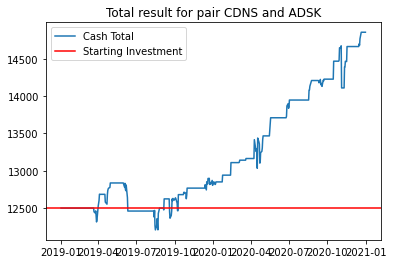

In [529]:
for i in range(len(df_test)):
    Profit_Loss(df_test[i])